## Importing Libraries

In [14]:
#tensorflow==2.14.0
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import scipy

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10  

### Loading Image Dataset

In [5]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255
)

# Validation data generator
val_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)


# Load training and validation data
train_generator = train_datagen.flow_from_directory(
    'E:/TEJ_WORKING_DATA/PROJECTS/DL/PROJ_5/paddy-leaf-disease-main/train_aug',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    'E:/TEJ_WORKING_DATA/PROJECTS/DL/PROJ_5/paddy-leaf-disease-main/validation',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    'E:/TEJ_WORKING_DATA/PROJECTS/DL/PROJ_5/paddy-leaf-disease-main/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 4019 images belonging to 5 classes.
Found 121 images belonging to 5 classes.
Found 212 images belonging to 5 classes.


In [6]:
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)  

Number of classes: 5


### Exploratory Data Analysis

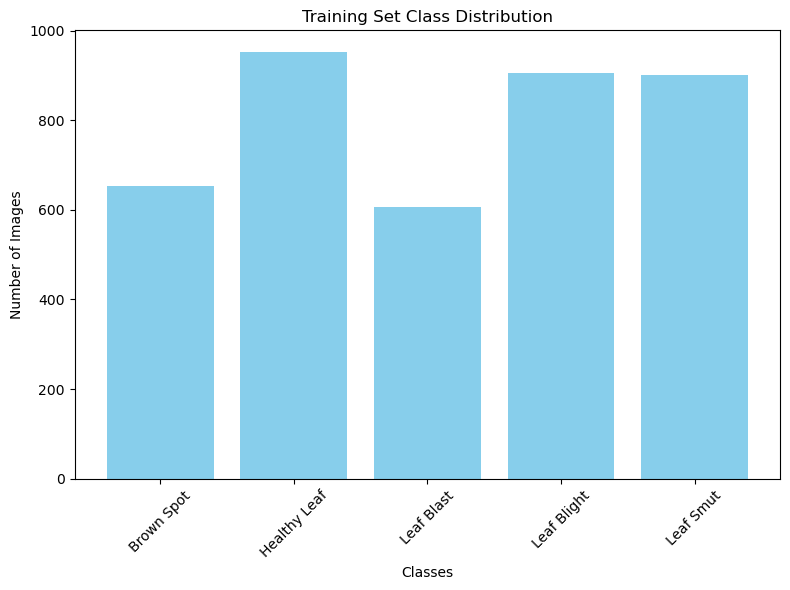

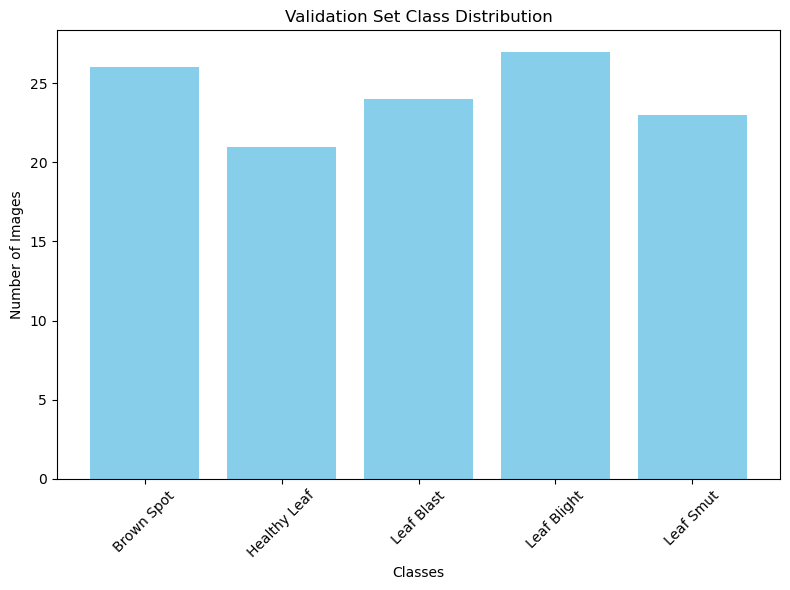

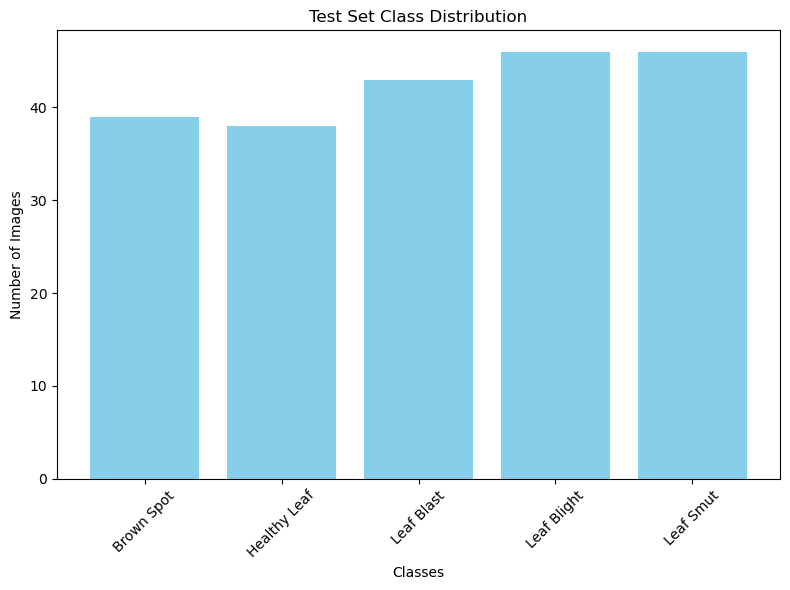

In [9]:
def plot_class_distribution(generator, title):
    class_counts = np.bincount(generator.classes)
    class_labels = list(generator.class_indices.keys())
    
    plt.figure(figsize=(8, 6))
    plt.bar(class_labels, class_counts, color='skyblue')
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution(train_generator, 'Training Set Class Distribution')
plot_class_distribution(validation_generator, 'Validation Set Class Distribution')
plot_class_distribution(test_generator, 'Test Set Class Distribution')


### Model Building

In [10]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 21913133 (83.59 MB)
Trainable params: 1051653 (4.01 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


### Model Training

In [12]:
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=3, min_lr=1e-6)

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
125/125 [==============================] - 487s 4s/step - loss: 0.4876 - accuracy: 0.8269 - val_loss: 0.3627 - val_accuracy: 0.8229 - lr: 0.0010
Epoch 2/100
125/125 [==============================] - 481s 4s/step - loss: 0.2100 - accuracy: 0.9217 - val_loss: 0.1886 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/100
125/125 [==============================] - 479s 4s/step - loss: 0.1344 - accuracy: 0.9561 - val_loss: 0.1415 - val_accuracy: 0.9167 - lr: 0.0010
Epoch 4/100
125/125 [==============================] - 481s 4s/step - loss: 0.0963 - accuracy: 0.9714 - val_loss: 0.0960 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 5/100
125/125 [==============================] - 481s 4s/step - loss: 0.0626 - accuracy: 0.9792 - val_loss: 0.0537 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 6/100
125/125 [==============================] - 481s 4s/step - loss: 0.0599 - accuracy: 0.9797 - val_loss: 0.1112 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 7/100
125/125 [==============================] - 480

In [ ]:
history.history['val_accuracy']

In [17]:
import pandas as pd
data=pd.DataFrame(model.history.history)

<Axes: >

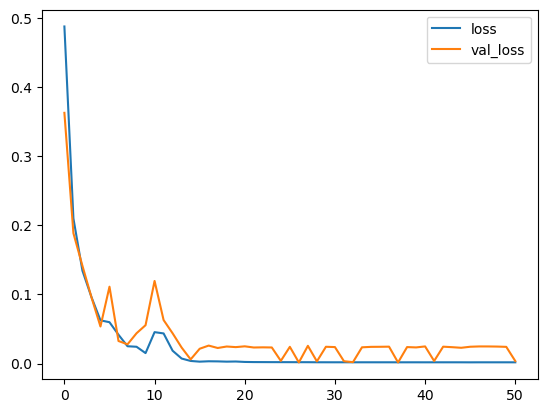

In [18]:
data[['loss','val_loss']].plot()

<Axes: >

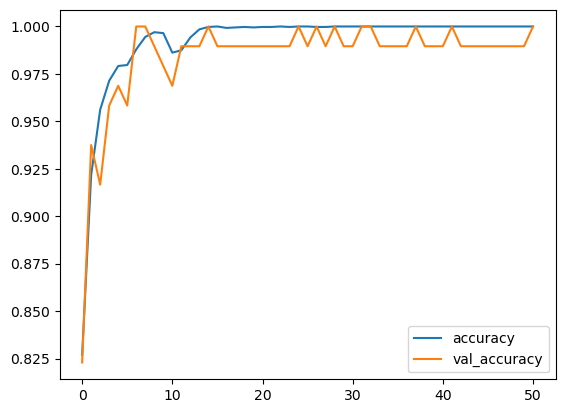

In [19]:
data[['accuracy','val_accuracy']].plot()

In [20]:
y_pred = model.predict(test_generator,verbose=1)
y_test = test_generator.classes

7/7 [==============================] - 31s 4s/step


### Classification Report

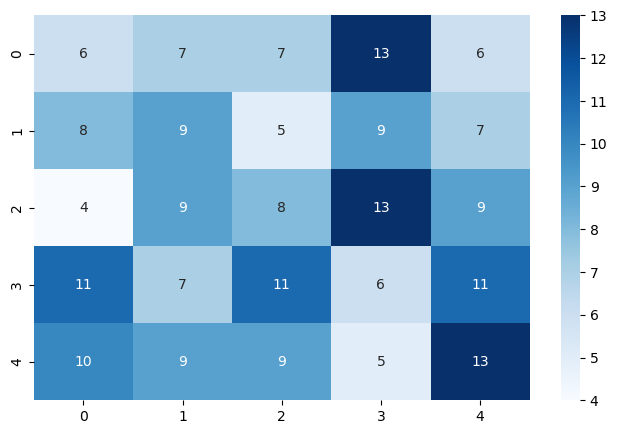

In [35]:
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt

if len(y_pred.shape) > 1:
    y_pred_labels = y_pred.argmax(axis=1)
else:
    y_pred_labels = y_pred

y_test_labels = y_test

plt.figure(figsize=(8, 5))
conf_matrix = metrics.confusion_matrix(y_test_labels, y_pred_labels)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.show()


### Testing

1/1 [==============================] - 3s 3s/step


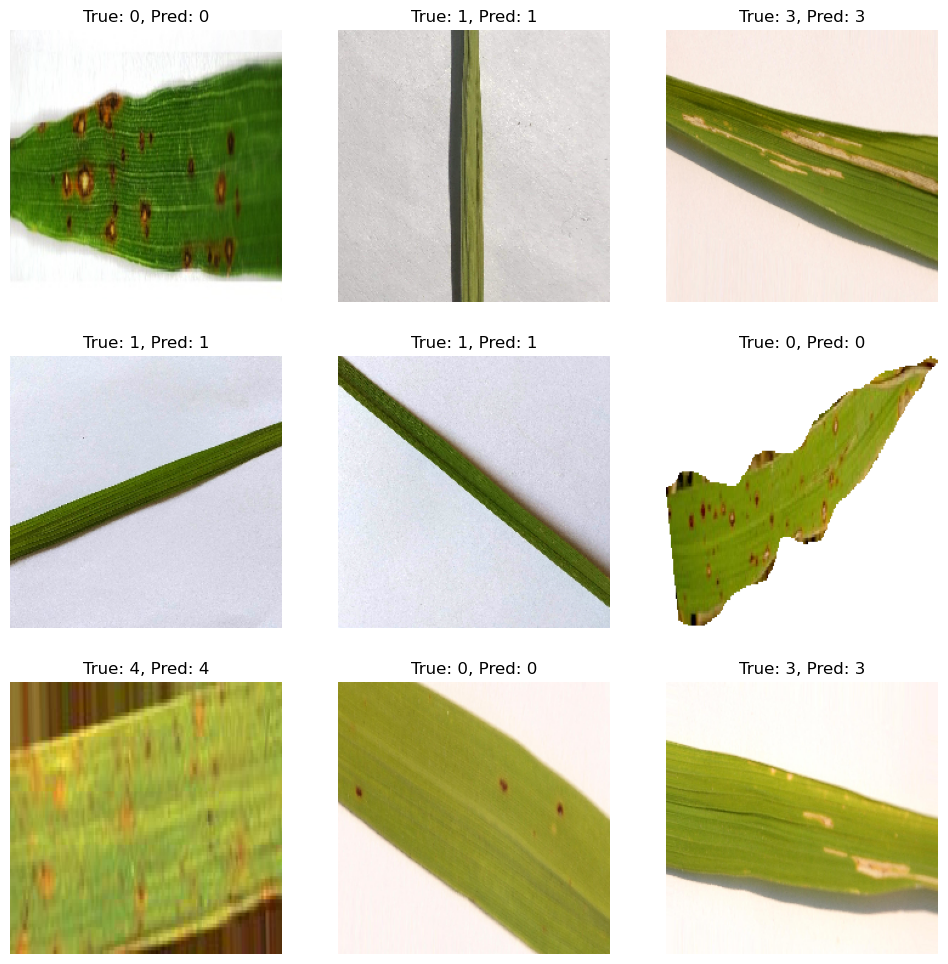

In [38]:
def plot_sample_predictions(generator, model, num_images=9):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)

    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"True: {true_classes[i]}, Pred: {predicted_classes[i]}")
        plt.axis('off')
    plt.show()

plot_sample_predictions(test_generator, model)

### Accuracy

In [50]:
print("The Training Accuracy of XCEPTION model is : ",history.history['accuracy'][-1]*100)
print("The Validation Accuracy of XCEPTION model is : ",history.history['val_accuracy'][-1]*100)

The Training Accuracy of XCEPTION model is :  100.0
The Validation Accuracy of XCEPTION model is :  98.95833134651184


In [47]:
print(confusion_matrix(y_test_labels, y_pred_labels))

[[ 6  7  7 13  6]
 [ 8  9  5  9  7]
 [ 4  9  8 13  9]
 [11  7 11  6 11]
 [10  9  9  5 13]]


### Model Saving

In [51]:
model.save('Model.h5')

C:\Users\intel 3\SoftwareFol\envs\proj5\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
